In [1]:
import cv2,os
from skimage import io
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve

import torch
from torch.utils.data import Dataset,TensorDataset,random_split,DataLoader,SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [157]:
data = "new"
chip="Hoechst"
if data == "new":
    X_Ctrl = np.load("./Datasets/Ctrl_"+chip+".npy",allow_pickle=True)[:3000]
    X_VPA = np.load("./Datasets/VPA_"+chip+".npy",allow_pickle=True)[:3000]
else:
    homepath="/groups/4/gaa50089/acd13264yb/NDAcquisition/Classification"
    X_Ctrl = np.load(homepath+"/datasets/01x40_padded.npy",allow_pickle=True)[:3000]
    X_VPA = np.load(homepath+"/datasets/02x40_padded.npy",allow_pickle=True)[:3000]

y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
y_VPA = torch.ones(len(X_VPA), dtype=torch.int64)
X = np.concatenate((X_Ctrl, X_VPA), axis=0)
y = torch.cat((y_Ctrl, y_VPA), 0)

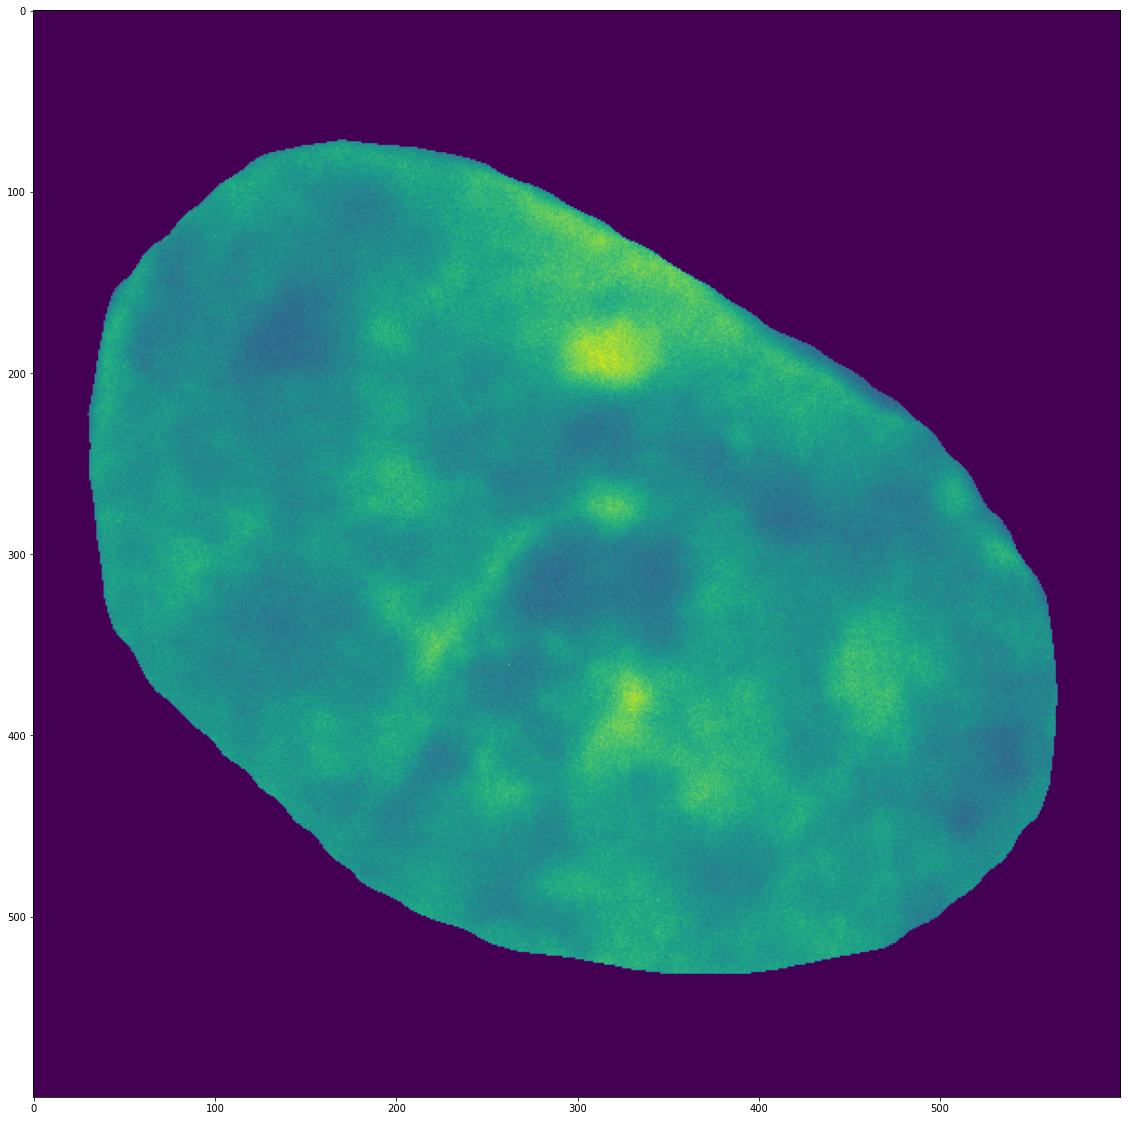

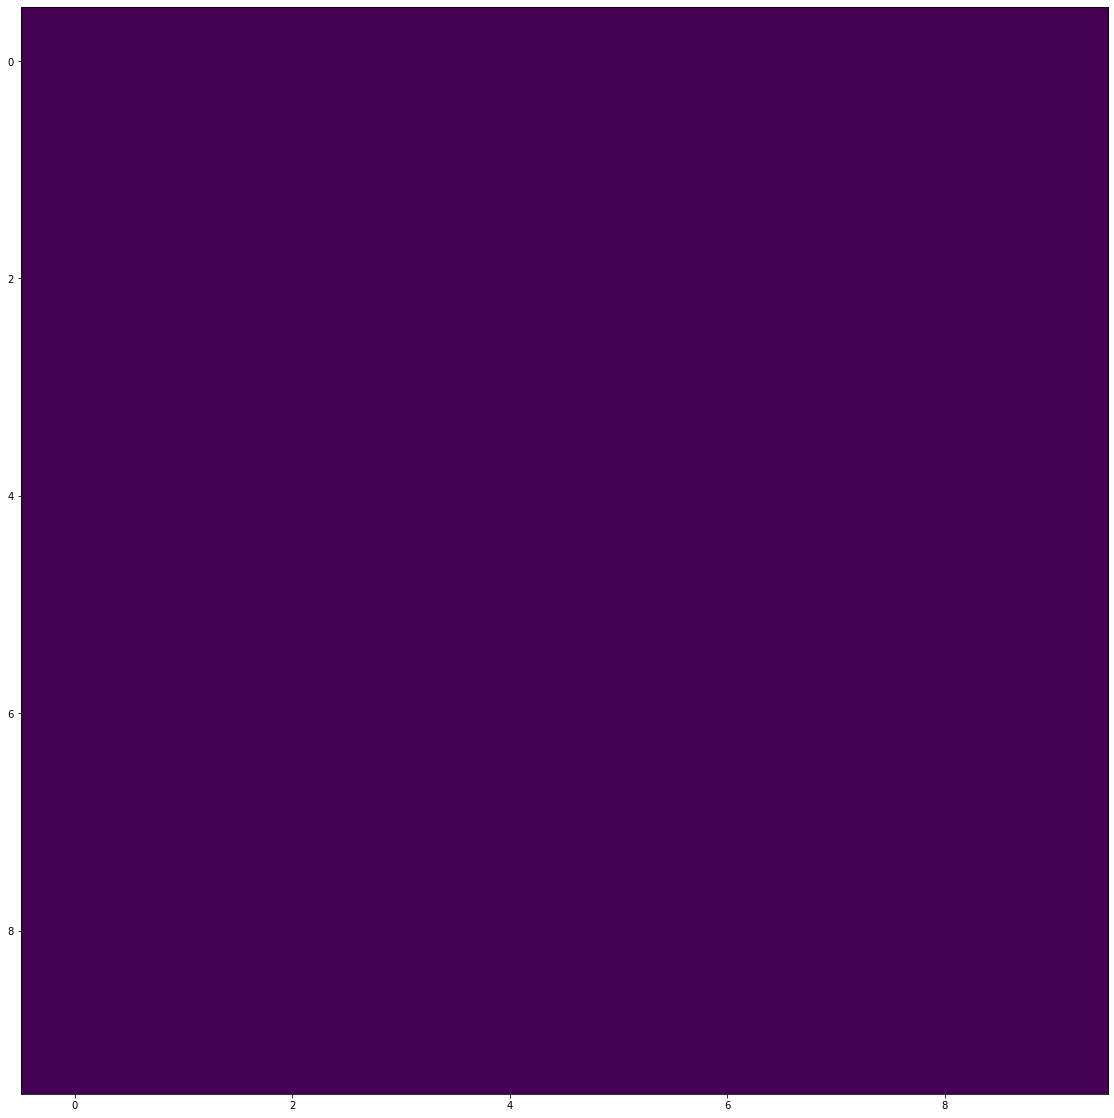

In [160]:
plt.figure(figsize=(20,20))
plt.imshow(X_Ctrl[1][:,:,0])
plt.figure(figsize=(20,20))
plt.imshow(X_Ctrl[1][66:76,40:50,0])

# 2. Data processing

In [162]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(100)])
class cell_dataset(Dataset):
    def __init__(self, x, y, transform=transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.transform(self.x[idx]).to(torch.float), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

dataset = cell_dataset(X, y)

In [163]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.
/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


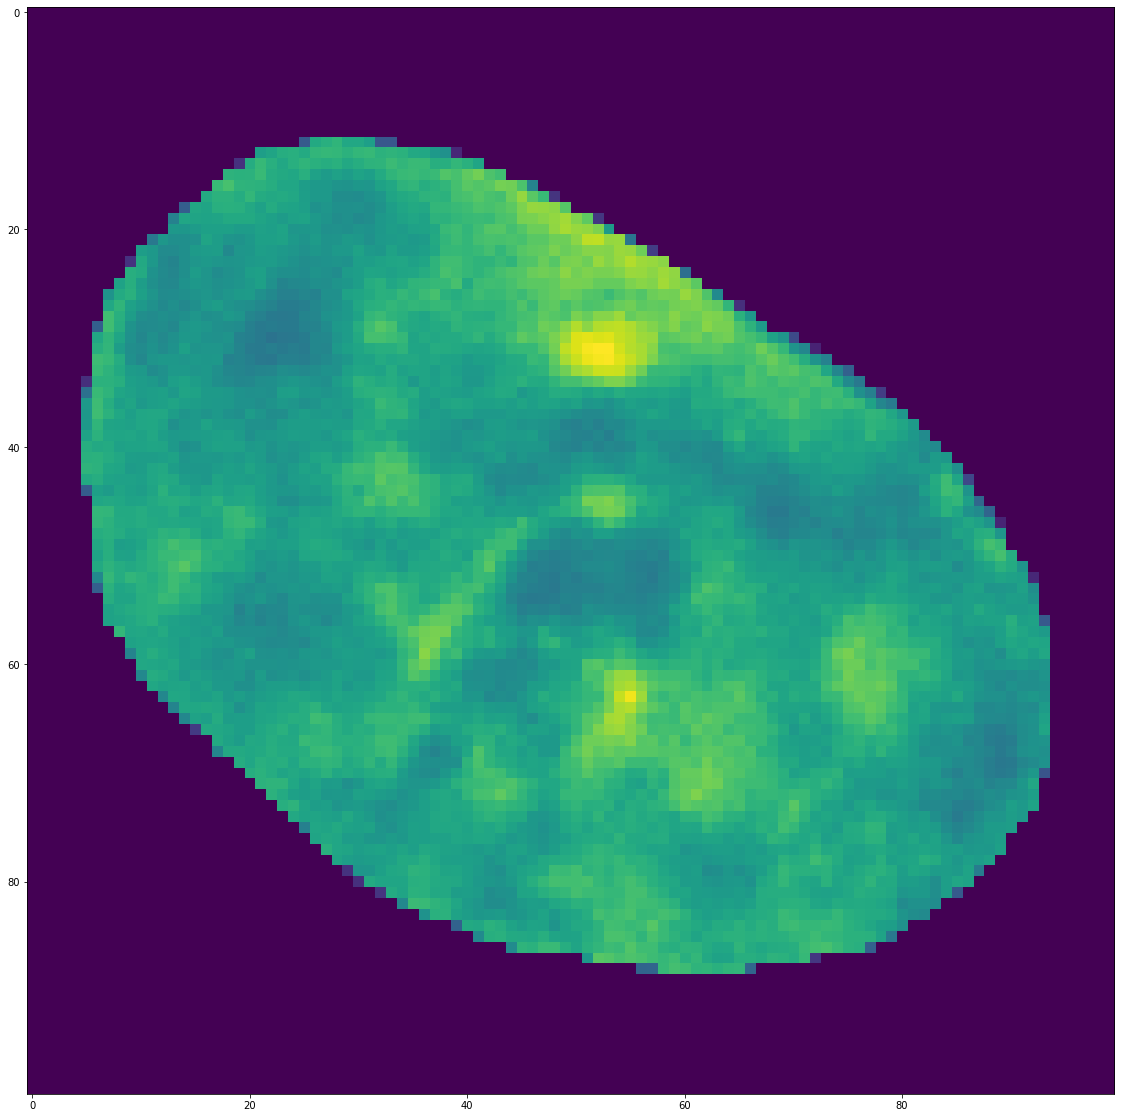

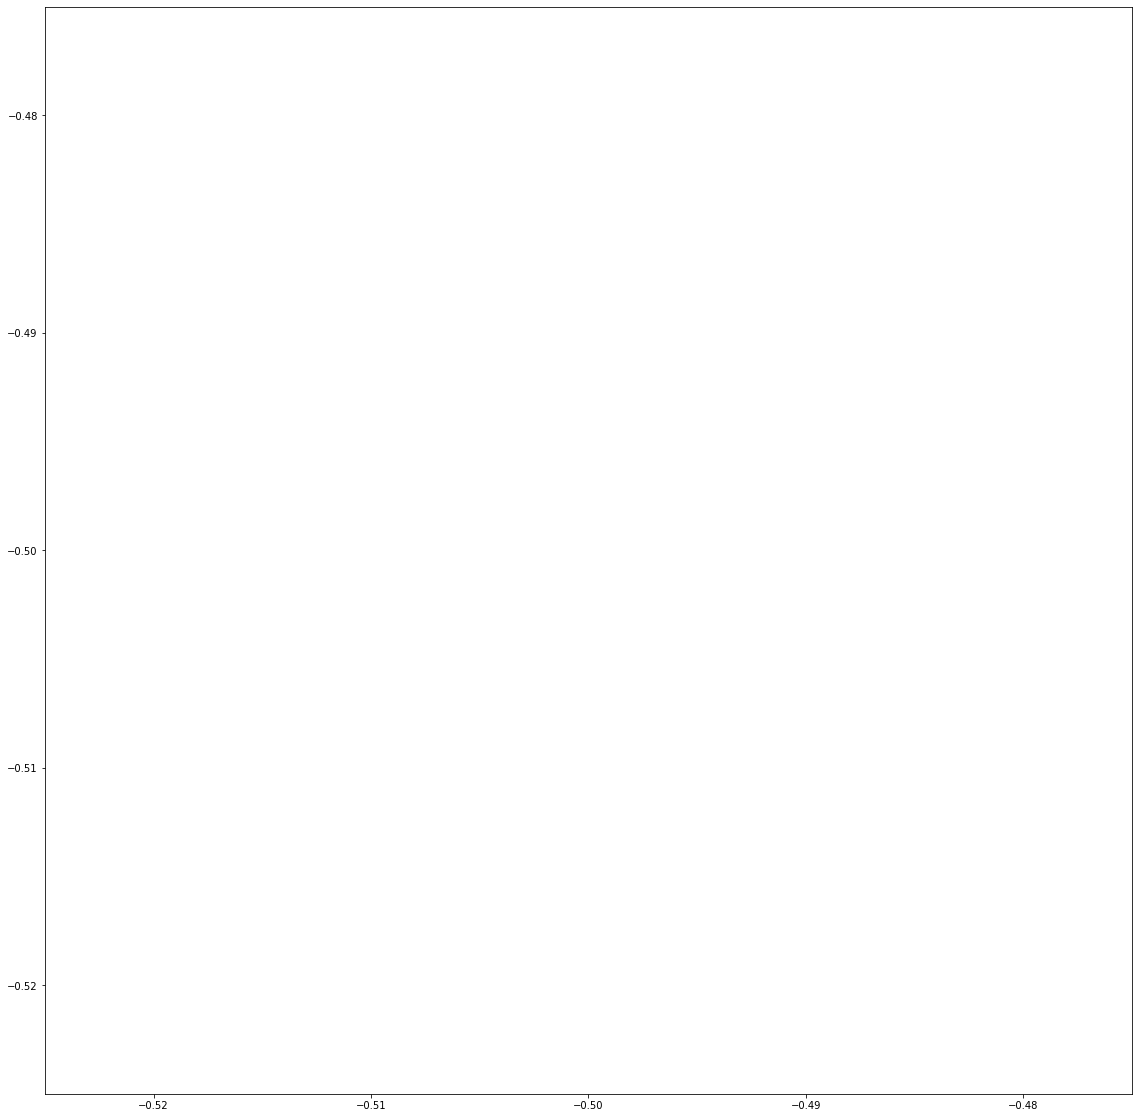

In [164]:
plt.figure(figsize=(20,20))
plt.imshow(dataset[1][0][0])
plt.figure(figsize=(20,20))
plt.imshow(dataset[1][0][0,370:430,240:300])

# 3. ResNet model

In [135]:
resnet="Resnet18"
newweightpath="/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/"+resnet+"_"+chip+".pkl"
oldweightpath="/groups/4/gaa50089/acd13264yb/NDAcquisition/Classification/models/"+resnet+"_Fold4.pkl"

In [136]:
weight=newweightpath
print(weight)
if resnet=="Resnet10_noavg":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*75*75, 2)
            self.resnet.load_state_dict(torch.load(weight))
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet10":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.fc = nn.Linear(128, 2)
            self.resnet.load_state_dict(torch.load(weight))
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet18":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.fc = nn.Linear(512, 2)
            self.resnet.load_state_dict(torch.load(weight))
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
    
model = ResNet().to(device)

/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/Resnet18_Hoechst.pkl


In [137]:
ngpu = 4
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [138]:
model.eval()
image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


# 4. Test

In [139]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.BCELoss()
def valid(model,device,dataloader_valid,loss_function):
    losses_valid = []
    n_val = 0
    acc_val = 0
    model.eval()
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    return np.mean(losses_valid), (acc_val/n_val)

In [140]:
true_y = 0
count = 0
total = 3000
for n in tqdm(range(total)):
    img = X_Ctrl[n]
    img = np.float32(img)/255
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    if pre_y==true_y:
        count+=1
print("Data01 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

true_y = 1
count = 0
total = 3000
for n in tqdm(range(total)):
    img = X_VPA[n]
    img = np.float32(img)/255
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    if pre_y==true_y:
        count+=1
print("Data01 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3000 [00:00<?, ?it/s]

Data01 acc: 0.000, count: 0, total: 3000 


/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3000 [00:00<?, ?it/s]

Data01 acc: 1.000, count: 3000, total: 3000 


In [141]:
loss_valid, acc_valid = valid(model,device,dataloader,loss_function)
print('Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(loss_valid, acc_valid))

Valid [Loss: 6.619, Accuracy: 0.500]


***

In [128]:
n_splits=5
splits=KFold(n_splits,shuffle=True,random_state=42)
batch_size = 128
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1), flush=True)
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    dataloader_valid = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    loss_valid, acc_valid = valid(model,device,dataloader_valid,loss_function)
    print('Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(loss_valid, acc_valid))

Fold 1
Valid [Loss: 0.050, Accuracy: 0.989]
Fold 2
Valid [Loss: 0.049, Accuracy: 0.995]
Fold 3
Valid [Loss: 0.042, Accuracy: 0.998]
Fold 4
Valid [Loss: 0.044, Accuracy: 0.995]
Fold 5
Valid [Loss: 0.117, Accuracy: 0.957]


# 4. Validate data

In [120]:
y = []
y_pred = []
out_pred = []
total = len(dataloader)

model.eval()
for n in range(total):
    img = dataloader[n][0]
    label = dataloader[n][1][1].item()
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    out_pred.append(output[0][1].item())
    y_pred.append(pred)
    y.append(label)

y = np.array(y)
y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print(resnet+"_"+chip)
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y,out_pred)))
print("total_test: {:}" .format(total))
fpr, tpr, thresholds = roc_curve(y, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

TypeError: 'DataLoader' object is not subscriptable

# 99. Save model

In [24]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.module.resnet.state_dict(),"Models/Resnet_H3K27ac.pkl")